In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from sklearn.metrics import auc

In [2]:
data14 = pd.read_csv("/Users/ryanraasch/Desktop/Data Informatics/pbp-2014.csv")
data15 = pd.read_csv("/Users/ryanraasch/Desktop/Data Informatics/pbp-2015.csv")
data16 = pd.read_csv("/Users/ryanraasch/Desktop/Data Informatics/pbp-2016.csv")
data17 = pd.read_csv("/Users/ryanraasch/Desktop/Data Informatics/pbp-2017.csv")
data18 = pd.read_csv("/Users/ryanraasch/Desktop/Data Informatics/pbp-2018.csv")

In [3]:
data = pd.concat([data14, data15, data16, data17, data18])

In [4]:
#data.to_csv('nflpbp.csv')

In [5]:
data=data.drop(["DefenseTeam", "NextScore","Description","TeamWin", "SeasonYear", "IsRush", "IsPass",
           "IsIncomplete", "IsSack", "IsChallenge", "IsChallengeReversed", "Challenger", "IsMeasurement", "IsFumble",
          "IsPenalty", "IsTwoPointConversion", "IsTwoPointConversionSuccessful", "RushDirection", "IsPenaltyAccepted",
          "PenaltyTeam", "IsNoPlay", "PenaltyType", "PenaltyYards", "Unnamed: 10", "Unnamed: 12",
           "Unnamed: 16", "Unnamed: 17"], axis=1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228232 entries, 0 to 45015
Data columns (total 18 columns):
GameId               228232 non-null int64
GameDate             228232 non-null object
Quarter              228232 non-null int64
Minute               228232 non-null int64
Second               228232 non-null int64
OffenseTeam          211602 non-null object
Down                 228232 non-null int64
ToGo                 228232 non-null int64
YardLine             228232 non-null int64
SeriesFirstDown      228232 non-null int64
Yards                228232 non-null int64
Formation            224504 non-null object
PlayType             220556 non-null object
IsTouchdown          228232 non-null int64
PassType             94485 non-null object
IsInterception       228232 non-null int64
YardLineFixed        228232 non-null int64
YardLineDirection    228232 non-null object
dtypes: int64(12), object(6)
memory usage: 33.1+ MB


In [7]:
data.OffenseTeam.unique()

array([nan, 'BUF', 'BAL', 'ATL', 'SF', 'CAR', 'ARI', 'NE', 'SEA', 'NYJ',
       'CHI', 'WAS', 'GB', 'TB', 'NO', 'CIN', 'HOU', 'KC', 'TEN', 'MIA',
       'OAK', 'PHI', 'CLE', 'JAX', 'PIT', 'MIN', 'DAL', 'DEN', 'IND',
       'NYG', 'DET', 'SD', 'LA', 'LAC'], dtype=object)

In [9]:
#See what kind of plays we have data on
data.PlayType.value_counts()

PASS                    94493
RUSH                    62581
KICK OFF                13140
PUNT                    12346
TIMEOUT                  8940
SACK                     6374
EXTRA POINT              5932
FIELD GOAL               5024
NO PLAY                  4236
SCRAMBLE                 3763
QB KNEEL                 1991
TWO-POINT CONVERSION      482
FUMBLES                   482
EXCEPTION                 417
CLOCK STOP                331
PENALTY                    24
Name: PlayType, dtype: int64

In [10]:
#remove rows that do not have a play type
data=data[data.PlayType.notnull()]

In [11]:
data.PlayType.unique()

array(['KICK OFF', 'RUSH', 'PASS', 'PUNT', 'NO PLAY', 'FIELD GOAL',
       'SACK', 'FUMBLES', 'SCRAMBLE', 'TIMEOUT', 'EXCEPTION',
       'EXTRA POINT', 'TWO-POINT CONVERSION', 'CLOCK STOP', 'PENALTY',
       'QB KNEEL'], dtype=object)

In [12]:
#plt.figure(figsize=(30,20))
#plt.bar(data.PlayType.value_counts().index, data.PlayType.value_counts().values)
#plt.title("Frequency of Play Type Recorded")
#plt.show()

In [13]:
#create data frame that only contains passes
passing = data[data.PlayType == "PASS"]

In [14]:
#create data frame that only contains run plays
run = data[data.PlayType == "RUSH"]

In [15]:
#concatenate the data frames
runpass = pd.concat([run,passing],axis=0, join='outer')

In [16]:
runpass.PlayType.value_counts()

PASS    94493
RUSH    62581
Name: PlayType, dtype: int64

In [17]:
runpass.Formation.value_counts()

SHOTGUN              81721
UNDER CENTER         58300
NO HUDDLE SHOTGUN    13898
NO HUDDLE             3147
WILDCAT                  4
FIELD GOAL               4
Name: Formation, dtype: int64

In [18]:
#remove the rows that have field goal and punt play formations. This will remove the fakes
runpass = runpass[runpass.Formation!='FIELD GOAL']
runpass = runpass[runpass.Formation!='PUNT']

In [19]:
#plt.figure(figsize=(30,20))
#plt.bar(data.Yards[data.Yards!=0].value_counts().index, data.Yards[data.Yards!=0].value_counts().values)
#plt.title("Yards per play")
#plt.show()

In [20]:
#fig,ax=plt.subplots(2)
#fig.set_figheight(20)
#fig.set_figwidth(20)
#ax[0].bar(data.Yards[data.PlayType=="PASS"].value_counts().index, data.Yards[data.PlayType=="PASS"].value_counts().values)
#ax[1].bar(data.Yards[data.PlayType=="RUSH"].value_counts().index, data.Yards[data.PlayType=="RUSH"].value_counts().values)
#ax[0].set_xlim(xmin=-10, xmax=100)
#ax[1].set_xlim(xmin=-10, xmax=100)
#ax[0].set_ylim(ymin=0, ymax=8000)
#ax[0].set_title('Yards Per Pass Play')
#ax[1].set_title('Yards Per Run Play')

#fig.tight_layout()

In [21]:
#clean the data for deep learning
runpass=runpass.drop(['YardLine','GameId','GameDate','Yards','IsTouchdown','PassType','IsInterception','year','month','day'], axis=1)

In [22]:
runpass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157070 entries, 92 to 20888
Data columns (total 11 columns):
Quarter              157070 non-null int64
Minute               157070 non-null int64
Second               157070 non-null int64
OffenseTeam          157068 non-null object
Down                 157070 non-null int64
ToGo                 157070 non-null int64
SeriesFirstDown      157070 non-null int64
Formation            157070 non-null object
PlayType             157070 non-null object
YardLineFixed        157070 non-null int64
YardLineDirection    157070 non-null object
dtypes: int64(7), object(4)
memory usage: 14.4+ MB


In [23]:
#combine minutes and seconds into one seconds column
runpass['Time']=runpass.Minute*60+runpass.Second

In [24]:
#create one-hot encoders for the categorical variables
cat_columns = ['Formation','PlayType','YardLineDirection']

In [25]:
runpass_proc = pd.get_dummies(runpass, prefix_sep = '_', columns=cat_columns)

In [26]:
runpass_proc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157070 entries, 92 to 20888
Data columns (total 18 columns):
Quarter                        157070 non-null int64
Minute                         157070 non-null int64
Second                         157070 non-null int64
OffenseTeam                    157068 non-null object
Down                           157070 non-null int64
ToGo                           157070 non-null int64
SeriesFirstDown                157070 non-null int64
YardLineFixed                  157070 non-null int64
Time                           157070 non-null int64
Formation_NO HUDDLE            157070 non-null uint8
Formation_NO HUDDLE SHOTGUN    157070 non-null uint8
Formation_SHOTGUN              157070 non-null uint8
Formation_UNDER CENTER         157070 non-null uint8
Formation_WILDCAT              157070 non-null uint8
PlayType_PASS                  157070 non-null uint8
PlayType_RUSH                  157070 non-null uint8
YardLineDirection_OPP          157070 no

In [27]:
#subset the data to just Rams on offense
rams = runpass_proc[runpass_proc["OffenseTeam"]=="LA"]

In [28]:
#specify the target variable
target_rams=rams.PlayType_PASS

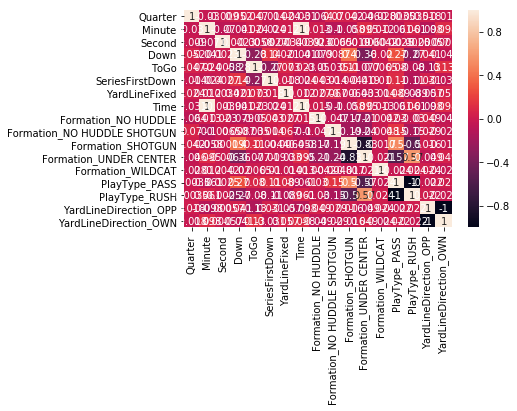

In [29]:
sns.heatmap(rams.corr(), annot=True)

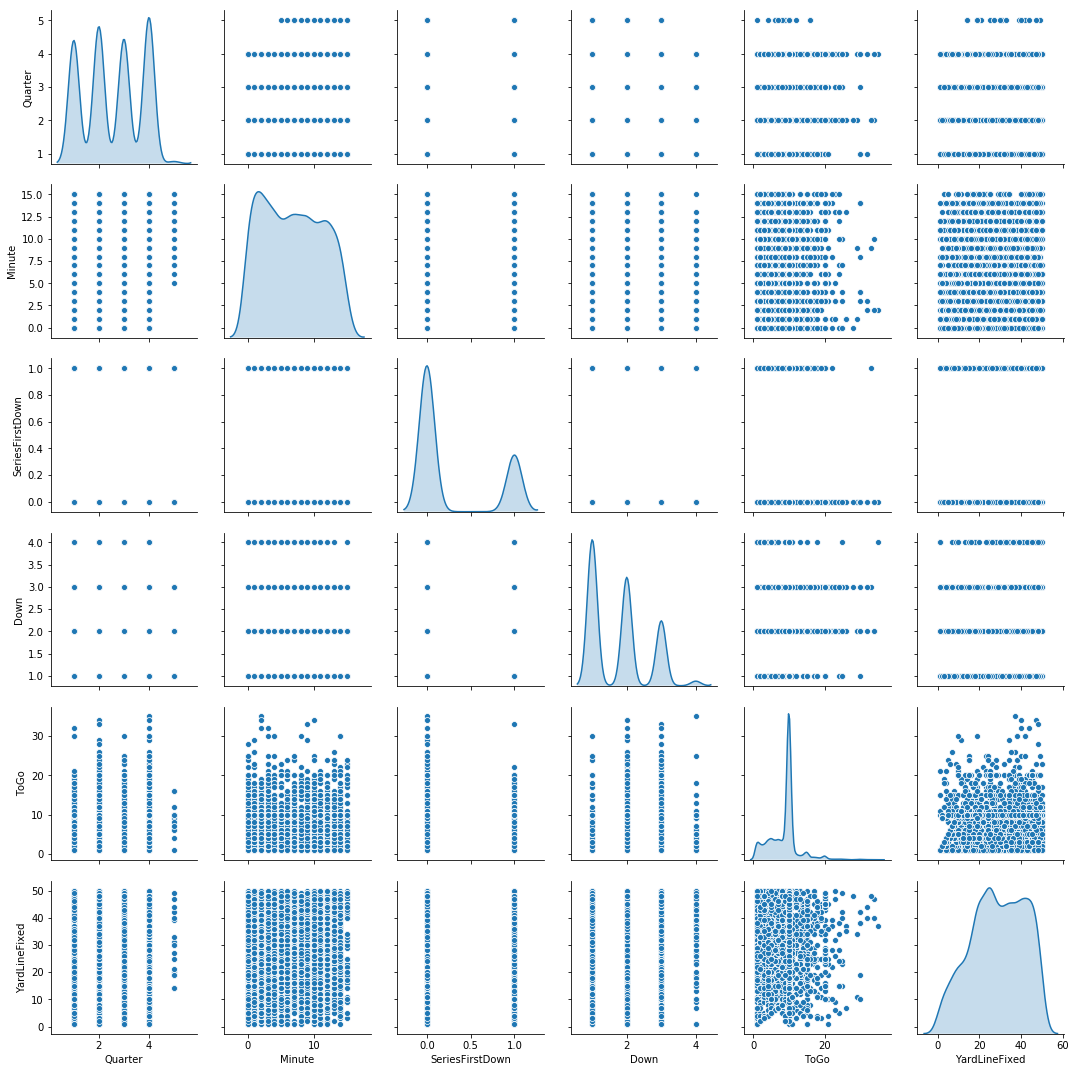

In [30]:
sns.pairplot(rams[["Quarter","Minute","SeriesFirstDown","Down", "ToGo", "YardLineFixed"]], diag_kind="kde")

In [31]:
rams = rams.drop(['Quarter','OffenseTeam', 'PlayType_RUSH','PlayType_PASS'], axis=1)

In [32]:
y_binary = to_categorical(target_rams)

In [33]:
rams.shape[1]

14

In [38]:
# Set up the model
model = Sequential()

# Add the first layer
model.add(Dense(15, activation='sigmoid',input_shape=(rams.shape[1],)))

#Add another layer
model.add(Dense(10, activation='sigmoid'))

# Add the output layer
model.add(Dense(2, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy']);

# Fit the model
model.fit(rams, y_binary, epochs=21);

Train on 4751 samples
Epoch 1/21
4751/4751 [==============================] - 1s 127us/sample - loss: 0.7004 - accuracy: 0.5478
Epoch 2/21
4751/4751 [==============================] - 0s 46us/sample - loss: 0.6774 - accuracy: 0.5801
Epoch 3/21
4751/4751 [==============================] - 0s 47us/sample - loss: 0.6754 - accuracy: 0.5801
Epoch 4/21
4751/4751 [==============================] - 0s 47us/sample - loss: 0.6735 - accuracy: 0.5801
Epoch 5/21
4751/4751 [==============================] - 0s 49us/sample - loss: 0.6722 - accuracy: 0.5801
Epoch 6/21
4751/4751 [==============================] - 0s 46us/sample - loss: 0.6692 - accuracy: 0.5802
Epoch 7/21
4751/4751 [==============================] - 0s 75us/sample - loss: 0.6652 - accuracy: 0.5860
Epoch 8/21
4751/4751 [==============================] - 0s 70us/sample - loss: 0.6534 - accuracy: 0.6171
Epoch 9/21
4751/4751 [==============================] - 0s 46us/sample - loss: 0.6317 - accuracy: 0.6525
Epoch 10/21
4751/4751 [=========

In [52]:
# Set up the model
model = Sequential()

# Add the first layer
model.add(Dense(10, activation='sigmoid',input_shape=(rams.shape[1],)))

#Add another layer
model.add(Dense(10, activation='sigmoid'))

#Add another layer
model.add(Dense(10, activation='sigmoid'))

#Add another layer
model.add(Dense(10, activation='sigmoid'))

#Add another layer
model.add(Dense(10, activation='sigmoid'))

# Add the output layer
model.add(Dense(2, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy']);

# Fit the model
model.fit(rams, y_binary, epochs=21);

Train on 4751 samples
Epoch 1/21
4751/4751 [==============================] - 1s 217us/sample - loss: 0.6839 - accuracy: 0.5729
Epoch 2/21
4751/4751 [==============================] - 1s 120us/sample - loss: 0.6817 - accuracy: 0.5694
Epoch 3/21
4751/4751 [==============================] - 1s 121us/sample - loss: 0.6744 - accuracy: 0.5801
Epoch 4/21
4751/4751 [==============================] - 1s 124us/sample - loss: 0.6437 - accuracy: 0.6180
Epoch 5/21
4751/4751 [==============================] - 1s 123us/sample - loss: 0.5469 - accuracy: 0.7197
Epoch 6/21
4751/4751 [==============================] - 1s 132us/sample - loss: 0.4995 - accuracy: 0.7742
Epoch 7/21
4751/4751 [==============================] - 1s 130us/sample - loss: 0.4977 - accuracy: 0.7707
Epoch 8/21
4751/4751 [==============================] - 1s 124us/sample - loss: 0.4930 - accuracy: 0.7789
Epoch 9/21
4751/4751 [==============================] - 1s 143us/sample - loss: 0.4908 - accuracy: 0.7785
Epoch 10/21
4751/4751 [=

In [40]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 10)                150       
_________________________________________________________________
dense_25 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_26 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_27 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_28 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 22        
Total params: 612
Trainable params: 612
Non-trainable params: 0
________________________________________________________

In [54]:
#create a function to pick the team and clean the data automatically
def pick_team(team):
    data = runpass_proc[runpass_proc["OffenseTeam"]==team]
    target=data.PlayType_PASS
    y_binary = to_categorical(target)
    data = data.drop(['Quarter','Minute','Second','OffenseTeam', 'PlayType_RUSH','PlayType_PASS'], axis=1)
    return data, y_binary

In [55]:
data, target=pick_team('LA')

In [56]:
datatest.shape[1]


NameError: name 'datatest' is not defined

In [57]:
def deeplearning(data, target,nodes1, nodes2):
    # Set up the model
    model = Sequential()

    # Add the first layer
    model.add(Dense(nodes1, activation='sigmoid',input_shape=(data.shape[1],)))

    #Add another layer
    model.add(Dense(nodes2, activation='sigmoid'))

    # Add the output layer
    model.add(Dense(2, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

    # Fit the model
    model.fit(data, target, epochs=25)
    return model

In [51]:
x=deeplearning(data,target, 50, 25)

Train on 4751 samples
Epoch 1/25
4751/4751 [==============================] - 1s 111us/sample - loss: 0.6806 - accuracy: 0.5704
Epoch 2/25
4751/4751 [==============================] - 0s 53us/sample - loss: 0.6734 - accuracy: 0.5801
Epoch 3/25
4751/4751 [==============================] - 0s 50us/sample - loss: 0.6694 - accuracy: 0.5820
Epoch 4/25
4751/4751 [==============================] - 0s 50us/sample - loss: 0.6490 - accuracy: 0.6165
Epoch 5/25
4751/4751 [==============================] - 0s 53us/sample - loss: 0.5937 - accuracy: 0.6889
Epoch 6/25
4751/4751 [==============================] - 0s 70us/sample - loss: 0.5386 - accuracy: 0.7413
Epoch 7/25
4751/4751 [==============================] - 0s 53us/sample - loss: 0.5090 - accuracy: 0.7674
Epoch 8/25
4751/4751 [==============================] - 0s 49us/sample - loss: 0.4967 - accuracy: 0.7746
Epoch 9/25
4751/4751 [==============================] - 0s 52us/sample - loss: 0.4948 - accuracy: 0.7754
Epoch 10/25
4751/4751 [=========

In [138]:
x.history['accuracy']

TypeError: 'History' object is not subscriptable

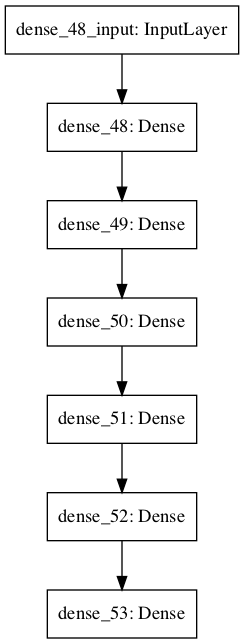

In [58]:
plot_model(model)

In [59]:
#for i in range(1,5):
#    for j in range(1, 5):
 #       x=deeplearning(data, target, i, j)
  #      bestnodes.append(x.history['accuracy'][-1])

In [65]:
#define function for getting 2019 team:
def season19(team):
    data19 = pd.read_csv("/Users/ryanraasch/Desktop/Data Informatics/pbp-2019.csv")
    data19 = data19.drop(["DefenseTeam", "NextScore","Description","TeamWin", "SeasonYear", "IsRush", "IsPass",
           "IsIncomplete", "IsSack", "IsChallenge", "IsChallengeReversed", "Challenger", "IsMeasurement", "IsFumble",
          "IsPenalty", "IsTwoPointConversion", "IsTwoPointConversionSuccessful", "RushDirection", "IsPenaltyAccepted",
          "PenaltyTeam", "IsNoPlay", "PenaltyType", "PenaltyYards", "Unnamed: 10", "Unnamed: 12",
           "Unnamed: 16", "Unnamed: 17"], axis=1)
    data19=data19[data19.PlayType.notnull()]
    passing19 = data19[data19.PlayType == "PASS"]
    run19 = data19[data19.PlayType == "RUSH"]
    runpass19 = pd.concat([run19,passing19],axis=0, join='outer')
    runpass19 = runpass19[runpass19.Formation!='FIELD GOAL']
    runpass19 = runpass19[runpass19.Formation!='PUNT']
    #clean the data for deep learning
    runpass19=runpass19.drop(['YardLine','GameId', 'GameDate', 'Yards','IsTouchdown', 'PassType','IsInterception'], axis=1)
    runpass19['Time']=runpass19.Minute*60+runpass19.Second
    cat_columns = ['Formation','PlayType','YardLineDirection']
    runpass_proc = pd.get_dummies(runpass, prefix_sep = '_', columns=cat_columns)
    data1, target1 = pick_team(team)
    return data1, target1

In [66]:
#create a function that inputs a team and runs the model along with evaluation
def modeltest(team, nodes1, nodes2):
    data, target = pick_team(team)
    model=deeplearning(data, target, nodes1, nodes2)
    datatest, targettest = season19(team)
    model.evaluate(datatest, targettest)
    return model

In [67]:
x=modeltest("LA", 50, 25)

Train on 4751 samples
Epoch 1/25
4751/4751 [==============================] - 1s 117us/sample - loss: 0.6835 - accuracy: 0.5609
Epoch 2/25
4751/4751 [==============================] - 0s 49us/sample - loss: 0.6739 - accuracy: 0.5801
Epoch 3/25
4751/4751 [==============================] - 0s 52us/sample - loss: 0.6677 - accuracy: 0.5832
Epoch 4/25
4751/4751 [==============================] - 0s 75us/sample - loss: 0.6517 - accuracy: 0.6064
Epoch 5/25
4751/4751 [==============================] - 0s 58us/sample - loss: 0.6153 - accuracy: 0.6773
Epoch 6/25
4751/4751 [==============================] - 0s 49us/sample - loss: 0.5579 - accuracy: 0.7426
Epoch 7/25
4751/4751 [==============================] - 0s 69us/sample - loss: 0.5247 - accuracy: 0.7579
Epoch 8/25
4751/4751 [==============================] - 0s 58us/sample - loss: 0.5001 - accuracy: 0.7746
Epoch 9/25
4751/4751 [==============================] - 0s 50us/sample - loss: 0.4975 - accuracy: 0.7714
Epoch 10/25
4751/4751 [=========

In [157]:
x=modeltest("NE", 50, 25)

Train on 5306 samples
Epoch 1/25
5306/5306 [==============================] - 1s 135us/sample - loss: 0.6797 - accuracy: 0.5780
Epoch 2/25
5306/5306 [==============================] - 0s 51us/sample - loss: 0.6710 - accuracy: 0.5925
Epoch 3/25
5306/5306 [==============================] - 0s 51us/sample - loss: 0.6678 - accuracy: 0.5946
Epoch 4/25
5306/5306 [==============================] - 0s 50us/sample - loss: 0.6535 - accuracy: 0.5978
Epoch 5/25
5306/5306 [==============================] - 0s 51us/sample - loss: 0.6033 - accuracy: 0.6738
Epoch 6/25
5306/5306 [==============================] - 0s 47us/sample - loss: 0.5488 - accuracy: 0.7410
Epoch 7/25
5306/5306 [==============================] - 0s 51us/sample - loss: 0.5142 - accuracy: 0.7678
Epoch 8/25
5306/5306 [==============================] - 0s 50us/sample - loss: 0.5075 - accuracy: 0.7701
Epoch 9/25
5306/5306 [==============================] - 0s 52us/sample - loss: 0.5029 - accuracy: 0.7746
Epoch 10/25
5306/5306 [=========

In [68]:
data, test = pick_team("LA")

In [119]:
data.head()

,Down,ToGo,SeriesFirstDown,YardLineFixed,Time,Formation_NO HUDDLE,Formation_NO HUDDLE SHOTGUN,Formation_SHOTGUN,Formation_UNDER CENTER,Formation_WILDCAT,YardLineDirection_OPP,YardLineDirection_OWN
44180,1,10,1,20,900,0,0,0,1,0,0,1
44243,1,17,0,24,900,0,0,1,0,0,1,0
44420,2,3,1,29,900,0,0,0,1,0,0,1
16553,1,10,0,20,900,0,0,0,1,0,0,1
44627,2,5,0,25,900,0,0,1,0,0,0,1


In [69]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(50, 50), random_state=1)
clf.fit(data, test)
MLPClassifier(alpha=1e-05, hidden_layer_sizes=(50, 50), random_state=1,solver='lbfgs')

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [70]:
[coef.shape for coef in clf.coefs_]

[(12, 50), (50, 50), (50, 2)]

In [71]:
datatest, targettest = season19("LA")

In [72]:
predictions = clf.predict(datatest)

In [120]:
from sklearn.metrics import classification_report,confusion_matrix

In [124]:
targettest[:,0]

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [126]:
predictions[:,0]

array([0, 0, 0, ..., 0, 0, 0])

In [127]:
print(confusion_matrix(targettest[:,0],predictions[:,0]))

[[2756    0]
 [1995    0]]


In [75]:
datatest.shape

(4751, 12)

In [76]:
target[:,0]

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [158]:
#logit model
data, target = pick_team("NE")
X = data
y = target[:,0]

In [159]:
X.head()

,Down,ToGo,SeriesFirstDown,YardLineFixed,Time,Formation_NO HUDDLE,Formation_NO HUDDLE SHOTGUN,Formation_SHOTGUN,Formation_UNDER CENTER,Formation_WILDCAT,YardLineDirection_OPP,YardLineDirection_OWN
1142,1,10,0,20,900,0,0,0,1,0,0,1
15212,1,10,0,20,900,0,0,0,1,0,0,1
18679,4,1,0,1,900,0,0,0,1,0,1,0
18774,2,6,0,35,900,0,0,0,1,0,0,1
21625,2,3,1,25,900,0,0,0,1,0,1,0


In [160]:
lr=LogisticRegression(fit_intercept=False)

In [161]:
lr.fit(X, y)

/Users/ryanraasch/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [162]:
lr.classes_

array([0., 1.], dtype=float32)

In [163]:
lr.coef_

array([[-3.61788811e-01, -1.11906734e-01, -7.90159390e-01,
        -7.74992863e-04, -3.89086770e-04,  1.97962420e+00,
        -1.37276709e+00, -5.92085423e-01,  1.73405702e+00,
         0.00000000e+00,  9.68684651e-01,  7.80144053e-01]])

In [164]:
pd.DataFrame(lr.coef_).apply(np.exp)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.696429,0.894128,0.453772,0.999225,0.999611,7.240022,0.253405,0.553172,5.663585,1.0,2.634477,2.181787


In [183]:
datatest, targettest = season19("NE")

In [184]:
preds=lr.predict(datatest)

In [185]:
preds

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [186]:
targettest[:,0]

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [187]:
diff=np.abs(preds-targettest[:,0])

In [188]:
1-np.sum(diff)/preds.shape[0]

0.781944967960799

In [189]:
runpass.PlayType.value_counts()

PASS    94490
RUSH    62580
Name: PlayType, dtype: int64

In [181]:
94490/(99490+62580)

0.5830196828530881

In [182]:
ROC CURVE
ERROR 
IMPORTANT VARS per technique

SyntaxError: invalid syntax (<ipython-input-182-ee690d3de9ea>, line 1)

In [79]:
from sklearn import metrics

In [80]:
datatest.head()

,Down,ToGo,SeriesFirstDown,YardLineFixed,Time,Formation_NO HUDDLE,Formation_NO HUDDLE SHOTGUN,Formation_SHOTGUN,Formation_UNDER CENTER,Formation_WILDCAT,YardLineDirection_OPP,YardLineDirection_OWN
44180,1,10,1,20,900,0,0,0,1,0,0,1
44243,1,17,0,24,900,0,0,1,0,0,1,0
44420,2,3,1,29,900,0,0,0,1,0,0,1
16553,1,10,0,20,900,0,0,0,1,0,0,1
44627,2,5,0,25,900,0,0,1,0,0,0,1


In [94]:
x.input

<tf.Tensor 'dense_66_input:0' shape=(None, 12) dtype=float32>

In [95]:
x.predict(data)

array([[0.17498848, 0.09834495],
       [0.0420742 , 0.28298444],
       [0.28470224, 0.06771851],
       ...,
       [0.05441591, 0.17839593],
       [0.1973373 , 0.06728947],
       [0.04799586, 0.18977422]], dtype=float32)

In [96]:
datatest, targettest = season19("NE")

In [97]:
targettest[:,0].shape

(5306,)

In [98]:
y_pred_keras[0::2].shape

(5306,)

In [99]:
from sklearn.metrics import roc_curve
y_pred_keras = x.predict(datatest).ravel()

In [100]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(targettest[:,0], y_pred_keras[0::2])

In [101]:

auc_keras = auc(fpr_keras, tpr_keras)

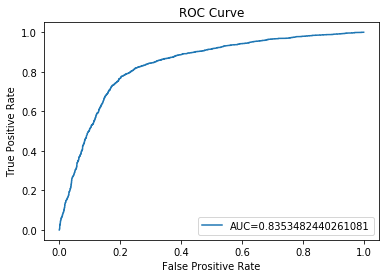

In [102]:
plt.plot(fpr_keras, tpr_keras, label="AUC="+str(auc_keras))
plt.legend(loc=4)
plt.xlabel('False Prositive Rate')
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [ ]:
#try to combine this all into one function